In [1]:
from gluonts.dataset.split import split
from gluonts.torch import PatchTSTEstimator
from gluonts.dataset.pandas import PandasDataset
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.common import ListDataset
import torch
from gluonts.model.predictor import Predictor
from sklearn.model_selection import train_test_split
import os
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

/home/deep/marius/ml/venv/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
from pathlib import Path
import os

load_dotenv()

True

In [3]:
from data.get_data import get_data_frame, get_max_user_count

In [19]:
df = get_data_frame(1)
df.set_index('timestamp', inplace=True)

In [20]:
freq = "15min"
prediction_length = 96

# Mock dataframe example (replace with your actual data)
# df = pd.DataFrame({"user_count": [...]}, index=pd.date_range(...))


train_data, test_data = train_test_split(
    df, 
    test_size=0.2,  # 20% for testing
    shuffle=True, 
    random_state=42  # For reproducibility
)

# Create training dataset
train_ds = ListDataset(
    [{"start": train_data.index[0], "target": train_data['user_count'].values}],
    freq=freq
)

# Create testing dataset
test_ds = ListDataset(
    [{"start": test_data.index[0], "target": test_data['user_count'].values}],
    freq=freq
)

# Set up CSV Logger
logger = CSVLogger(save_dir="./logs/", name="patchtst_training")

# Define checkpointing callback to save the model
model_checkpoint = ModelCheckpoint(
    dirpath="./models/",
    filename="best_model",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
)

# Initialize estimator
estimatorTST = PatchTSTEstimator(
    prediction_length=prediction_length,
    context_length=prediction_length * 10,
    patch_len=16,
    stride=8,
    trainer_kwargs={
        "accelerator": "gpu",
        "max_epochs": 30,
        "logger": logger,
        "callbacks": [model_checkpoint],
        "log_every_n_steps": 1,
    }
)

In [6]:
# Train the model using the train() method
predictorTST = estimatorTST.train(train_ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/deep/marius/ml/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/deep/marius/ml/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/deep/marius/ml/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model 

Training: |                                                                                     | 0/? [00:00<?…

Epoch 0, global step 50: 'train_loss' reached 8.48790 (best 8.48790), saving model to './logs/patchtst_training/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
/home/deep/marius/ml/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
Epoch 1, global step 100: 'train_loss' reached 7.71747 (best 7.71747), saving model to './logs/patchtst_training/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.66177 (best 7.66177), saving model to './logs/patchtst_training/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.64852 (best 7.64852), saving model to './logs/patchtst_training/version_3/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: '

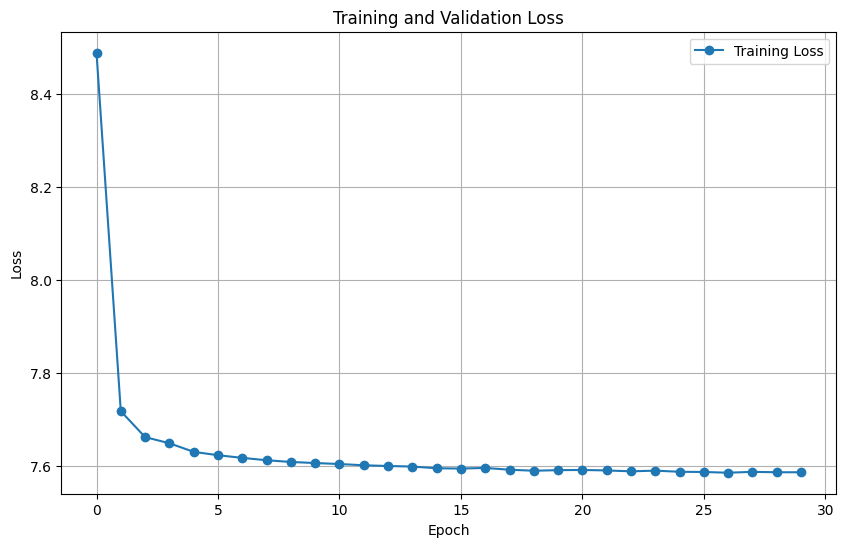

In [7]:
# Read the CSV log and plot training and validation losses
metrics_path = Path(logger.log_dir) / "metrics.csv"
metrics = pd.read_csv(metrics_path)

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(metrics["epoch"], metrics["train_loss"], label="Training Loss", marker="o")
if "val_loss" in metrics.columns:
    plt.plot(metrics["epoch"], metrics["val_loss"], label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [8]:
# Save the predictor
model_save_path = Path(f"./models/1")
if not model_save_path.exists():
    os.makedirs(model_save_path)

predictorTST.serialize(model_save_path)

# Make forecasts
forecasts = list(predictorTST.predict(test_ds))

In [9]:
from data.get_data import load_model_and_get_prediction
import datetime

In [11]:
int(datetime.datetime.now().replace(hour=0, minute=0, second=0).timestamp() + datetime.time)

1732402800

In [16]:
date = datetime.datetime.now().replace(hour=0, minute=0, second=0) + datetime.timedelta(days=1)
df = pd.DataFrame(load_model_and_get_prediction(int(date.timestamp()), 1))

In [17]:
df

,timestamp,predicted_user_count
0,2024-11-25 00:00:00+01:00,509.395996
1,2024-11-25 00:15:00+01:00,493.416168
2,2024-11-25 00:30:00+01:00,563.399658
3,2024-11-25 00:45:00+01:00,549.982422
4,2024-11-25 01:00:00+01:00,535.909180
...,...,...
91,2024-11-25 22:45:00+01:00,512.965942
92,2024-11-25 23:00:00+01:00,549.748230
93,2024-11-25 23:15:00+01:00,487.227661
94,2024-11-25 23:30:00+01:00,555.556091


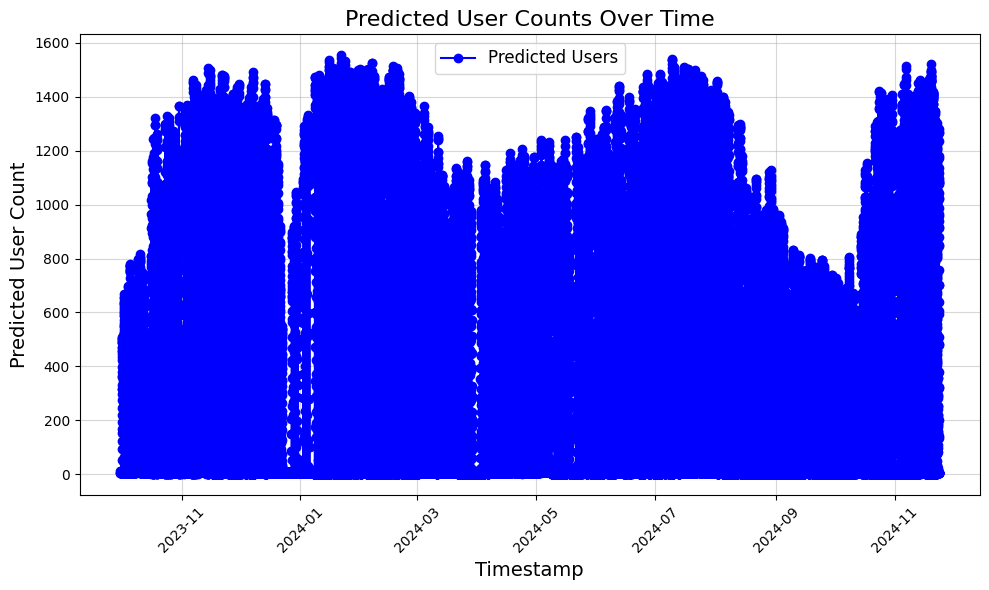

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['predicted_user_count'], marker='o', linestyle='-', color='blue', label='Predicted Users')

plt.title('Predicted User Counts Over Time', fontsize=16)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Predicted User Count', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

plt.show()